# Setup use case

### Enable  the APIs if they are not enabled 

In [ ]:

'''!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com
'''

## Uncomment all needed cells if you need to install missing packages 

In [ ]:
# Install ai platform and kfp
#!pip3 install {USER_FLAG} google-cloud-aiplatform==1.3.0 --upgrade
#!pip3 install {USER_FLAG} kfp --upgrade


In [ ]:
#!pip install google_cloud_pipeline_components

In [ ]:
#!gcloud auth login if needed

In [ ]:
# Restart the kernel
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)


#### Set up the global variables 

In [ ]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

CLIENT_PROJECT_NAME = 'test' 
REGION="europe-west1"

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]

# Set bucket name
BUCKET_NAME="gs://"+PROJECT_ID+"-bucket-" + CLIENT_PROJECT_NAME

# Bucket data
BUCKET_DATA  = BUCKET_NAME + "/data/"

# Create bucket
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
USER_FLAG = "--user"

# Create bucket
!gsutil mb -c standard -l $REGION $BUCKET_NAME


# Model Target 
TARGET= "target"

## Import Libraries
 * Artifact,
 * Dataset,
 * Input,
 * Model,
 * Output,
 * Metrics,
 * ClassificationMetrics
 * InputPath
 * OutputPath

In [2]:
from typing import NamedTuple
import typing
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component, 
                        OutputPath, 
                        InputPath)

from kfp.v2 import compiler
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
from google_cloud_pipeline_components import aiplatform as gcc_aip
import pandas as pd



### Create pipeline

We create 4 components:  
- Load data   
- Train a  model
- Evaluate the model 
- Deploy the model

The components have dependencies on `pandas`, `sklearn`.

In [3]:
# Import data to GCS 
!gsutil cp ../data/*.csv $BUCKET_DATA
df_raw_data = pd.read_csv("../data/train.csv", delimiter=";")
df_raw_data.head()

Copying file://../data/test.csv [Content-Type=text/csv]...
Copying file://../data/train.csv [Content-Type=text/csv]...                     
/ [2 files][ 16.3 KiB/ 16.3 KiB]                                                
Operation completed over 2 objects/16.3 KiB.                                     


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,73960.044714,84403.422147,81100.834420,78754.613864,63716.529225,71794.028431,81012.621631,65109.664137,81444.184151,79405.859619,59386.103715,56478.892203,76611.413924,88685.805901,70858.600148,99536.372888,75156.105188
1,87196.743619,97688.792258,93162.659601,106943.277331,63716.529225,106327.598799,97231.352482,65440.025158,109821.459689,89395.444452,88829.850983,80106.612534,82711.507077,84128.484305,82292.083678,79086.943250,75995.843234
2,84406.173121,80768.608520,82488.153945,64577.221383,63716.529225,107533.416515,97020.719614,63599.442325,81444.184151,83644.594356,66897.749926,71873.957366,74250.819737,81926.632298,67693.694533,81981.011610,78760.212392
3,77106.608256,52401.890830,57943.848129,56539.654989,63716.529225,61817.883698,85056.772701,72566.384334,68545.422543,68364.314626,91545.727481,59524.974615,62271.939137,73743.935769,69077.030762,60483.006478,80101.853092
4,88476.318181,63491.398777,72973.708834,61949.179344,63716.529225,61529.486063,64477.941478,77521.799655,56936.537096,83477.206477,63328.371431,63641.302199,74148.678642,56405.631360,89648.917260,57825.143545,80202.857141


### Read the dataset 

In [4]:
@component(
    packages_to_install=["pandas", "pyarrow", "scikit-learn==1.0.0", "gcsfs"],
    base_image="python:3.9",
    output_component_file="get_test_train_data.yaml"
)

def get_data(
    url: str,
    dataset_train: Output[Dataset],
    dataset_test: Output[Dataset]
):
    import pandas as pd
    import numpy as np
   
    train, test = pd.read_csv(url + 'train.csv', sep=';'), pd.read_csv(url + 'test.csv', sep=';')
    train.to_csv(dataset_train.path + ".csv" , sep=';',index=False, encoding='utf-8-sig')
    test.to_csv(dataset_test.path + ".csv" , sep=';',index=False, encoding='utf-8-sig')
    


#### Train the model


In [5]:
@component(
    packages_to_install = ["pandas", "pyarrow", "scikit-learn==1.0.0","gcsfs"], 
    base_image="python:3.9",
    output_component_file="train_model.yaml"
)
def model_training(
    target: str,
    dataset:  Input[Dataset],
    model: Output[Model], 
):
    
    from sklearn.linear_model import Ridge
    import pandas as pd
    import pickle

    data = pd.read_csv(dataset.path+".csv", sep=';')
    print(data.columns)
    model_reg = Ridge(alpha= 102 ,positive = True)
    model_reg.fit(
        data.drop(columns=target),
        data[target]
    )
    
    model.metadata["framework"] = "Ridge"
    file_name = model.path + f".pkl"
    with open(file_name, 'wb') as file:  
        pickle.dump(model_reg, file)
        

#### Evaluate the model 

In [6]:
@component(
    packages_to_install = ["pandas", "pyarrow", "scikit-learn==1.0.0", "gcsfs"], 
    base_image="python:3.9",
    output_component_file="evaluate_model.yaml"
)
def model_evaluation(
    target : str,
    test_set:  Input[Dataset],
    model: Input[Model],
    thresholds_dict_str: str,
    kpi: Output[Metrics]
) -> NamedTuple("output", [("deploy", str)]):

    #from sklearn.linear_model import Ridge
    import pandas as pd
    import logging 
    import pickle
    from sklearn.metrics import r2_score
    import json
    import typing

    
    def threshold_check(val1, val2):
        cond = "false"
        if val1 >= val2 :
            cond = "true"
        return cond

    data = pd.read_csv(test_set.path+".csv", sep = ';')
    file_name = model.path + ".pkl"
    with open(file_name, 'rb') as file:  
        model_reg = pickle.load(file)
    
    y_test = data.drop(columns=target)
    y_target=data[target]
    y_pred = model_reg.predict(y_test)
       
    R2 = r2_score(y_target, y_pred)
    thresholds_dict = json.loads(thresholds_dict_str)
    model.metadata["R2"] = float(R2)
    kpi.log_metric("R2", float(R2))
    deploy = threshold_check(float(R2), int(thresholds_dict['R2']))
    return (deploy,)
    

    

### Deploy model 

In [7]:
@component(
    packages_to_install=["google-cloud-aiplatform", "pandas", "pyarrow", "scikit-learn==1.0.0", "gcsfs",  "kfp"],
    base_image="python:3.9",
    output_component_file="pipeline_coponents.yml"
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    serving_container_image_uri : str, 
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)

    DISPLAY_NAME  = "test"
    MODEL_NAME = "test-ridge"
    ENDPOINT_NAME = "test_endpoint"
    
    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=project, 
        location=region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=project, location=region
        )
    endpoint = create_endpoint()   
    
    
    #Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = DISPLAY_NAME, 
        artifact_uri = model.uri[:-5], #.replace("model", ""),
        serving_container_image_uri =  serving_container_image_uri,
        serving_container_health_route=f"/v1/models/{MODEL_NAME}",
        serving_container_predict_route=f"/v1/models/{MODEL_NAME}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": MODEL_NAME,
    },       
    )
    model_deploy = model_upload.deploy(
        machine_type="n1-standard-4", 
        endpoint=endpoint,
        traffic_split={"0": 100},
        deployed_model_display_name=DISPLAY_NAME,
    )

    # Save data to the output params
    vertex_model.uri = model_deploy.resource_name

In [8]:
from datetime import datetime

TIMESTAMP =datetime.now().strftime("%Y%m%d%H%M%S")
DISPLAY_NAME = 'pipeline-test-job{}'.format(TIMESTAMP)

#### Create the Pipeline

Once you have created all the needed components define the pipeline and then compile it into a `.json` file.

In [9]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="pipeline-test",
    
)
def pipeline(
    url: str = BUCKET_NAME + "/data/",
    target : str = TARGET,
    project: str = PROJECT_ID,
    region: str = REGION, 
    display_name: str = DISPLAY_NAME,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"R2":0.45}',
    serving_container_image_uri: str = "europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    ):
    
    data_op = get_data(url)
    
    train_model_op = model_training(target, data_op.outputs["dataset_train"])
    
    model_evaluation_op = model_evaluation(
        target,
        test_set=data_op.outputs["dataset_test"],
        model=train_model_op.outputs["model"],
        thresholds_dict_str = thresholds_dict_str, # I deploy the model only if the model performance is above the threshold
    )
    
    with dsl.Condition(
        model_evaluation_op.outputs["deploy"]=="true",
        name="deploy-model",
    ):
           
        deploy_model_op = deploy_model(
        model=train_model_op.outputs['model'],
        project=project,
        region=region, 
        serving_container_image_uri = serving_container_image_uri,
        )
    

### Compile and run the pipeline

In [10]:
compiler.Compiler().compile(pipeline_func=pipeline,package_path='ml_pipeline.json')

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


The pipeline compilation generates the **ml_pipeline.json** job spec file.

### Create a run 

In [12]:
start_pipeline = pipeline_jobs.PipelineJob(
    display_name="pipeline-test",
    template_path="ml_pipeline.json",
    enable_caching=False,
    location=REGION,
)

In [13]:
start_pipeline.run()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/716383847597/locations/europe-west1/pipelineJobs/pipeline-test-20220309213045
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/716383847597/locations/europe-west1/pipelineJobs/pipeline-test-20220309213045')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/pipeline-test-20220309213045?project=716383847597
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/716383847597/locations/europe-west1/pipelineJobs/pipeline-test-20220309213045 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/716383847597/locations/europe-west1/pipelineJobs/pipeline

### Pipeline execution

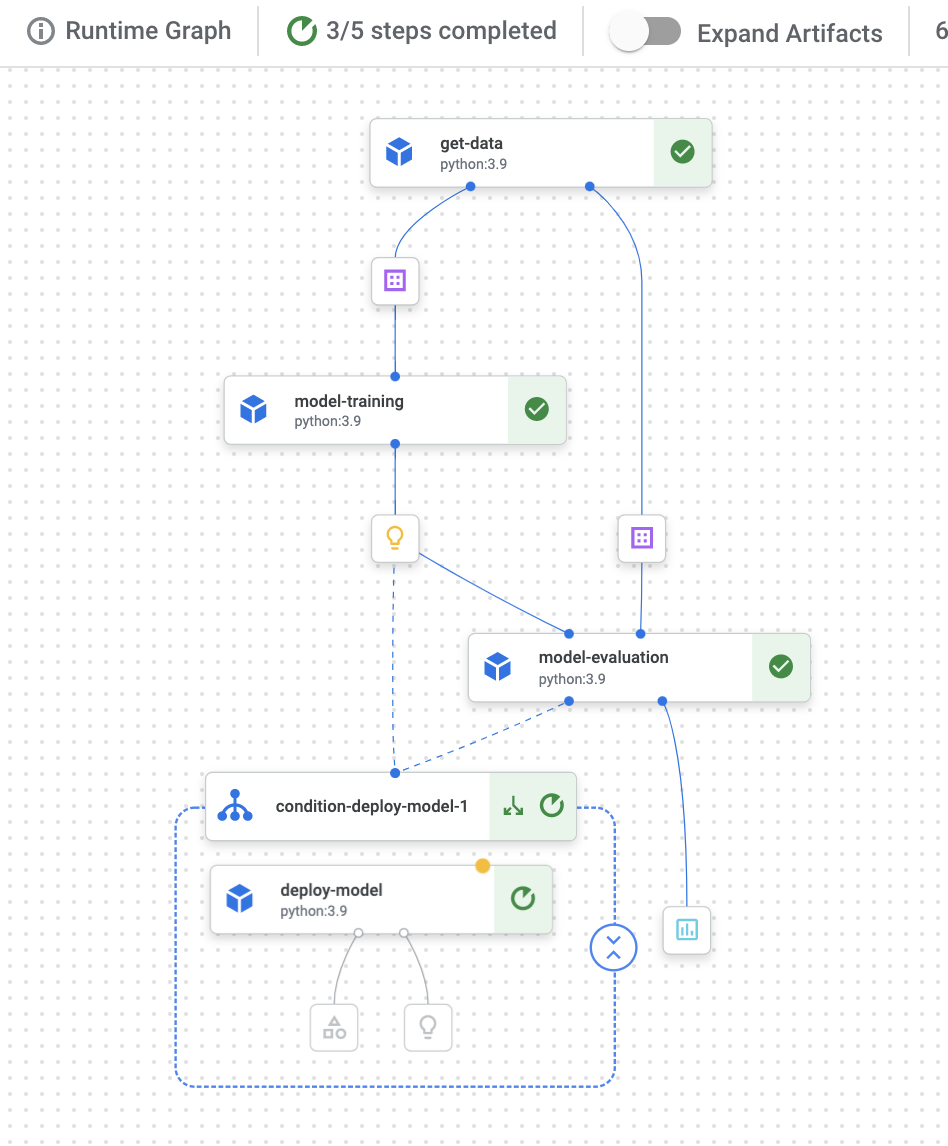

In [18]:
from IPython.display import Image
Image(filename='../data/pipeline.png')

### List all models 

In [19]:
DISPLAY_NAME = "pipeline-test"
! gcloud ai models list --region={REGION} --filter={DISPLAY_NAME}

Using endpoint [https://europe-west1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
8295313854267654144  test


### Schedule pipeline 

The scheduled jobs are supported by the Cloud Scheduler and Cloud Functions. 
Check that the APIs Cloud Scheduler, Cloud Functions are enabled. 

### Run recurrent pipeline

In [ ]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
                project_id=PROJECT_ID,
                region=REGION,
                )

SERVICE_ACCOUNT = (
    "XXXXX-compute@developer.gserviceaccount.com" 
)
response = api_client.create_schedule_from_job_spec(
    enable_caching=True,
    job_spec_path="ml_pipeline.json",
    schedule="0 0 * * 1", //once per week on Monday
    time_zone="Europe/Brussels",  # change this as necessary
    parameter_values={"display_name": DISPLAY_NAME},
    pipeline_root=PIPELINE_ROOT,  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    #service_account=SERVICE_ACCOUNT,
    
)


Once the scheduled job is created, you can see it listed in the Cloud Scheduler panel in the Console.

### Test the batch prediction  

In [ ]:
# Define variables 
job_display_name = "test-batch-prediction-"
MODEL_NAME="test-ridge"
ENDPOINT_NAME="test_endpoint"
BUCKET_URI="gs://BUCKET_NAME/...."
input_file_name="test.csv"

# Get model id
MODEL_ID=!(gcloud ai models list --region=$REGION \
           --filter=display_name=$MODEL_NAME)
MODEL_ID=MODEL_ID[2].split(" ")[0]

model_resource_name = f'projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL_ID}'
gcs_source= [f"{BUCKET_URI}/{input_file_name}"]
gcs_destination_prefix=f"{BUCKET_URI}/output"

def batch_prediction_job(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source: str,
    gcs_destination_prefix: str,
    machine_type: str,
    starting_replica_count: int = 1, # The number of nodes for this batch prediction job. 
    max_replica_count: int = 1,    
):   
    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_resource_name)

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        instances_format='csv', #json
        gcs_source=[f"{BUCKET_URI}/{input_file_name}"],
        gcs_destination_prefix=f"{BUCKET_URI}/output",
        machine_type=machine_type, # must be present      
    )
    batch_prediction_job.wait()
    print(batch_prediction_job.display_name)
    print(batch_prediction_job.state)
    return batch_prediction_job

batch_prediction_job(PROJECT_ID, REGION, model_resource_name, job_display_name, gcs_source, gcs_destination_prefix, machine_type="n1-standard-2")

### Send an online prediction request
Each prediction request must be max. 1.5 MB.

In [21]:
ENDPOINT_NAME="test_endpoint"
INSTANCE = df_raw_data.drop(columns=TARGET).sample(3).values.tolist()
ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)'\
              --filter=display_name=$ENDPOINT_NAME \
              --sort-by=creationTimeStamp | tail -1)

ENDPOINT_ID = "8836168022017179648" #ENDPOINT_ID[0]

def endpoint_predict(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction

endpoint_predict(PROJECT_ID, REGION, INSTANCE, ENDPOINT_ID)


Prediction(predictions=[65590.2995476206, 69313.17079237182, 49339.46236792032], deployed_model_id='555877894631456768', explanations=None)

In [22]:
TOKEN = !(gcloud auth print-access-token)
TOKEN = TOKEN[0]

In [23]:
import requests
import json
 
ENDPOINT_NAME="test_endpoint"
ENDPOINT_ID = "8836168022017179648"


data = {
    'instances': df_raw_data.drop(columns=TARGET).sample(5).values.tolist()
}
 
def predict_(projet_id,region, endpoint_id,token, data ):
    api = 'https://{}-aiplatform.googleapis.com/v1/projects/{}/locations/{}/endpoints/{}:predict'.format(region,projet_id, region, endpoint_id)
    headers = {'Authorization': 'Bearer ' + token }
    response = requests.post(api, json=data, headers=headers)
    pred = response.json()#['predictions']
    return pred
   
    
predict_(PROJECT_ID, REGION, ENDPOINT_ID,TOKEN, data)

{'predictions': [74258.98909053489,
  66394.24438585842,
  78130.90941697714,
  51983.58689599352,
  65786.52503782249],
 'deployedModelId': '555877894631456768',
 'model': 'projects/716383847597/locations/europe-west1/models/8295313854267654144',
 'modelDisplayName': 'test'}